In [1]:
import warnings
warnings.filterwarnings("ignore")
from evaluation.mol_structure import list_of_smiles_to_nx_graphs
from evaluation.mol_structure import draw_one_mol, draw_graphs
from evaluate import evaluate
from sklearn.utils import shuffle
#import utils.graph_generators as gen
import torch
import networkx as nx
import os 
import sys
current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)
import rdkit
import numpy as np
from evaluation.utils import get_data,  get_mock_data,get_generated_data,get_clean_datasets
import json


c:\Users\cs843\AppData\Local\Programs\Python\Python310\lib\site-packages\neptune\common\warnings.py:62: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  warnings.warn(
c:\Users\cs843\AppData\Local\Programs\Python\Python310\lib\site-packages\neptune\common\warnings.py:62: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  warnings.warn(


# Data collection

## Hide

In [3]:
#disable  
from rdkit import RDLogger 
RDLogger.EnableLog('rdApp.*')
#RDLogger.DisableLog('rdApp.*')        
name='ames'                                                                                                                                                                                                                                                                                                                                                                                                                                                               
path='data/smiles/{}/train1_smiles.txt'.format(name)
#rom data.smiles.carcinogens import test_smiles
reference_smiles_list = []
with open(path) as my_file:
    for line in my_file:
        reference_smiles_list.append(line)
reference_nx_graphs=list_of_smiles_to_nx_graphs(reference_smiles_list)
"""
print(reference_smiles_list[0])
mol = Chem.MolFromSmiles(reference_smiles_list[0])
Chem.Kekulize(mol)
Chem.RemoveStereochemistry(mol)
Chem.rdmolops.AddHs(mol)
print(mol_to_smiles([mol])[0])
print(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0])
rdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(reference_smiles_list[0]))
rdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]))

#rdkit.Chem.Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]),   Chem.MolFromSmiles(reference_smiles_list[0])  ]  )

#rdkit.Chem.Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]),   Chem.MolFromSmiles(reference_smiles_list[0])  ]  )
"""

'\nprint(reference_smiles_list[0])\nmol = Chem.MolFromSmiles(reference_smiles_list[0])\nChem.Kekulize(mol)\nChem.RemoveStereochemistry(mol)\nChem.rdmolops.AddHs(mol)\nprint(mol_to_smiles([mol])[0])\nprint(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0])\nrdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(reference_smiles_list[0]))\nrdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]))\n\n#rdkit.Chem.Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]),   Chem.MolFromSmiles(reference_smiles_list[0])  ]  )\n\n#rdkit.Chem.Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]),   Chem.MolFromSmiles(reference_smiles_list[0])  ]  )\n'

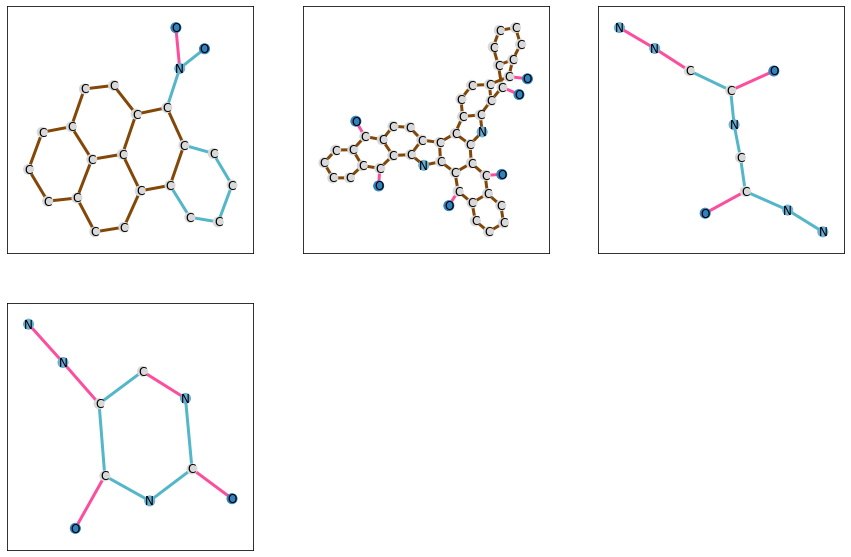

In [66]:
list_of_G=reference_nx_graphs[:4]
#for n , d in (G.nodes().items() ):
    #print(str(d['label'][0]))

draw_graphs(list_of_G)

[N-]=[N+]=CC(=O)NCC(=O)NN



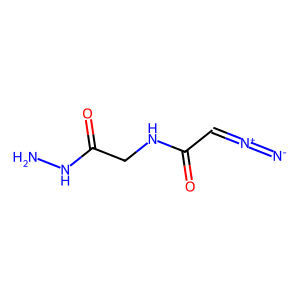

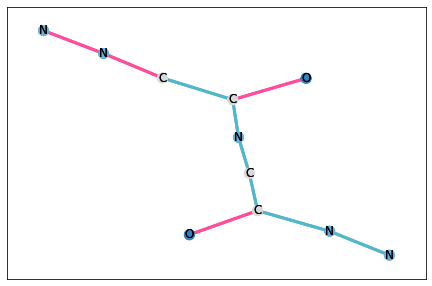

In [68]:
draw_one_mol(reference_nx_graphs[2])
print(reference_smiles_list[2])
draw_one_mol(reference_nx_graphs[2])

rdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(reference_smiles_list[2]))


In [69]:
reference_nx_graphs[0].nodes(data=True)

NodeDataView({0: {'label': 8, 'attr': [7, 0, 1, 5, 0, 0, 1, 0, 0], 'label_name': 'O'}, 1: {'label': 7, 'attr': [6, 0, 3, 6, 0, 0, 1, 0, 0], 'label_name': 'N'}, 2: {'label': 8, 'attr': [7, 0, 1, 4, 0, 0, 1, 0, 0], 'label_name': 'O'}, 3: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 4: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 5: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 6: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 7: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 8: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 9: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 10: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 11: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 12: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 13: {'label': 6, 'attr': [5, 0, 3,

In [70]:
reference_nx_graphs[0].edges(data=True)

EdgeDataView([(0, 1, {'label': 2, 'attr': [1, 0, 1], 'edge_label': 'DOUBLE'}), (1, 2, {'label': 1, 'attr': [0, 0, 1], 'edge_label': 'SINGLE'}), (1, 3, {'label': 1, 'attr': [0, 0, 1], 'edge_label': 'SINGLE'}), (3, 4, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (3, 16, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (4, 5, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (4, 22, {'label': 1, 'attr': [0, 0, 0], 'edge_label': 'SINGLE'}), (5, 6, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (5, 19, {'label': 1, 'attr': [0, 0, 0], 'edge_label': 'SINGLE'}), (6, 7, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (6, 17, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (7, 8, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (8, 9, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (9, 10, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (9, 18, {'label': 1, 'attr': [3, 0, 1], 'edge_label':

## Show


In [7]:
        
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
dataset_name='bbb_martins'
train_graphs, train_targets,  test_graphs, test_targets , train1_graphs , train1_targets,train2_graphs, train2_targets, valid_graphs,valid_targets =get_data(dataset_name, return_smiles=False)
reference_graphs,reference_targets=train_graphs+test_graphs, train_targets+test_targets
generated_pos, generated_neg=get_generated_data(dataset_name)
generated_graphs,generated_targets = generated_pos + generated_neg, [1]*len(generated_pos)+[0]*len(generated_neg)
generated_graphs, generated_targets = shuffle(generated_graphs, generated_targets)
reference_graphs, generated_graphs=get_clean_datasets(reference_graphs,generated_graphs )

In [10]:
device=torch.device('cpu')
metrics_type=['structural','nn','molecular']
#levae it blank to compute all the structural structures 
structural_statistic=['all'] 
evaluate(reference_graphs[:5], generated_graphs[:5], device,  metrics_type, structural_statistic)

Now computing classifier based metrics

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Cannot compute the classifier based metrics
Now computing structural based metrics


# Run

In [3]:


def run_all():
    device=torch.device('cpu')
    metrics_type=['nn','molecular','structural','auc_roc']
    #levae it blank to compute all the structural structures 
    structural_statistic=['all'] 
    for dataset_name in current_smiles_datasets: 
        train_graphs, train_targets,  test_graphs, test_targets , train1_graphs , train1_targets,train2_graphs, train2_targets, _,_ =get_data(dataset_name, return_smiles=False)
        reference_nx_graphs,reference_targets=train_graphs+test_graphs, train_targets+test_targets
        generated_pos, generated_neg=get_generated_data(dataset_name)
        generated_graphs,generated_targets = generated_pos + generated_neg, [1]*len(generated_pos)+[0]*len(generated_neg)
        generated_nx_graphs, generated_targets = shuffle(generated_graphs, generated_targets)
        splits_for_auc_roc=[train_graphs, train_targets,test_graphs, test_targets,train1_graphs,train1_targets,train2_graphs, train2_targets, generated_graphs,generated_targets]
        reference_nx_graphs,generated_nx_graphs=get_clean_datasets(reference_nx_graphs,generated_nx_graphs)
        metrics=evaluate(reference_nx_graphs, generated_nx_graphs, device,  metrics_type, structural_statistic, *splits_for_auc_roc)
        metrics['dataset']=dataset_name
        metrics['generator_name']='STGG'
        print(metrics)
        with open('smiles_datasets_experiments.txt', 'a+') as f:
            f.write(json.dumps(dict) +'\n')

'\nprint(reference_nx_graphs[0].nodes(data=True))\nprint(reference_nx_graphs[0].edges(data=True))\n\n'

{'activations_time': 0.45316004753112793,
 'fid': 3.3299173196610354e-08,
 'fid_time': 0.4601743221282959,
 'kid': -0.27056575,
 'kid_time': 7.3782408237457275,
 'precision': 1.0,
 'recall': 1.0,
 'f1_pr': 1.00001,
 'precision_time': 0.7771599292755127,
 'recall_time': 0.7771599292755127,
 'f1_pr_time': 0.7771599292755127,
 'density': 1.2053639846743296,
 'coverage': 1.0,
 'f1_dc': 1.0931303090896223,
 'density_time': 0.6621618270874023,
 'coverage_time': 0.6621618270874023,
 'f1_dc_time': 0.6621618270874023,
 'mmd_rbf': 0,
 'mmd_rbf_time': 1.262209177017212,
 'mmd_linear': 0.0,
 'mmd_linear_time': 0.45316004753112793,
 'nspdk_mmd': 0.08083532491372947,
 'nspdk_mmd_time': 14.770469427108765,
 'valid': 1.0,
 'unique@1000': 1.0,
 'unique@10000': 1.0,
 'FCD/Test': 0.06483010510226318,
 'SNN/Test': 1.0,
 'Frag/Test': 0.9985447050085542,
 'Scaf/Test': nan,
 'FCD/TestSF': 53.23109144992008,
 'SNN/TestSF': 0.09263560138642787,
 'Frag/TestSF': 0.0,
 'Scaf/TestSF': nan,
 'IntDiv': 0.27166667461

# New metric  (Step 1 and Step 2)

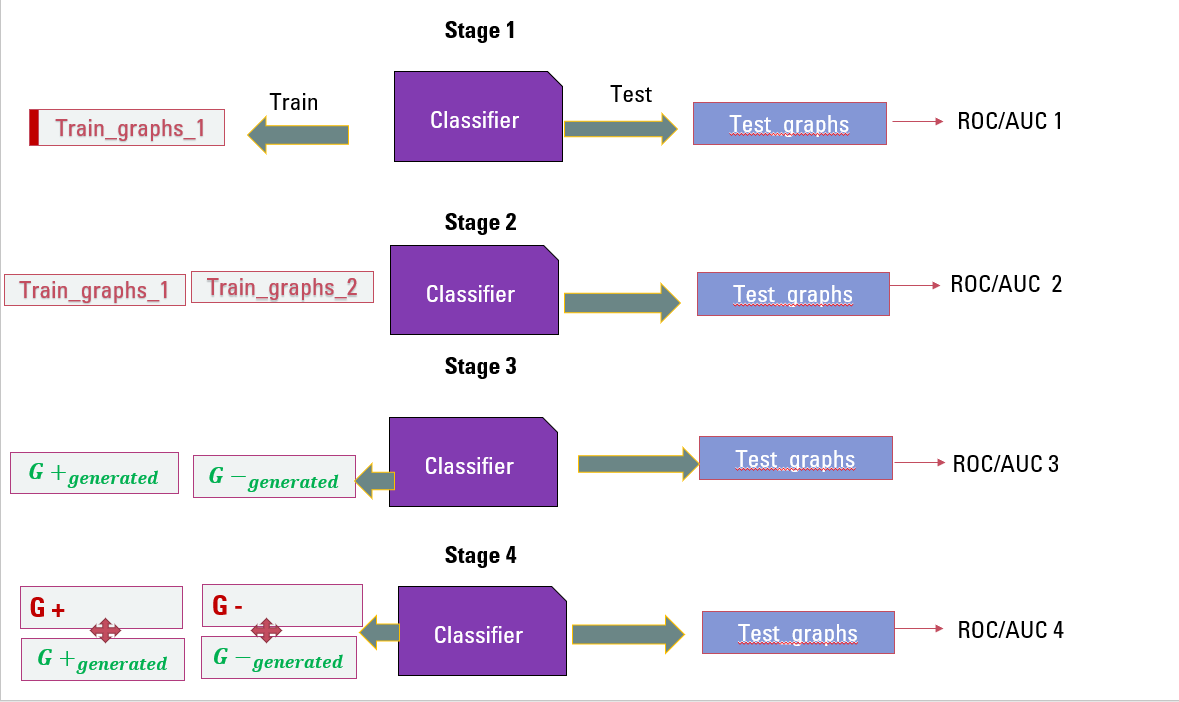

In [3]:
#example on bb_martics with mock generated from ames without knowing the splits 
classifier_nn=AucRocEvaluation(classifier_type='nn')
classifier_nspdk=AucRocEvaluation(classifier_type='scikit')
m1=classifier_nspdk.evaluate_with_random_splits(reference_graphs, reference_targets, generated_graphs, generated_targets)
m2=classifier_nn.evaluate_with_random_splits(reference_graphs, reference_targets, generated_graphs, generated_targets)
m1,m2

0.8885263612791704 0.9020851339671564 0.5417999135695765 0.8573465859982715
0.7790298184961106 0.7169079515989628 0.5 0.5


(0.0, 0)

In [5]:
#example on bb_martics with mock generated from ames
classifier_nn=AucRocEvaluation(classifier_type='nn')
classifier_nspdk=AucRocEvaluation(classifier_type='scikit')
m1=classifier_nspdk.evaluate(train_graphs, train_targets,test_graphs, test_targets,train1_graphs,train1_targets,train2_graphs, train2_targets, generated_graphs,generated_targets)
m2=classifier_nn.evaluate(train_graphs, train_targets,test_graphs, test_targets,train1_graphs,train1_targets, train2_graphs, train2_targets,generated_graphs,generated_targets)
m1,m2

0.8499150885962382 0.8472716203659201 0.475567945144029 0.8158544009740781
0.8028613540965746 0.8424172514338812 0.49163702778044793 0.4780512031785703


(0, 0.0)

# NN classifier  with ogb AtomEncoder, BondEncoder

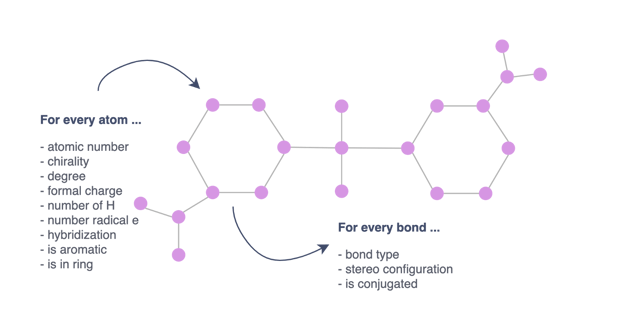